# Final Project

1. What is/are the most popular videos
2. What is/are the most popular channels
3. Plot Time series chart of all views
4. Which youtube categories are the most popular
5. Average time it takes a video to trend since publish time
6. Try to find features that make a video popular, X: title(caps?), channel, video category, time video is posted, tags, description. y = total_engagement -> p value/t test to determine most significant predictors?
Define total_engagement: views + likes + dislikes + comments

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime

In [2]:
yt_videos = pd.read_csv('USvideos.csv')

# Remove all Nan rows
yt_videos = yt_videos.dropna()

# Remove repeat videos but keep the one that has the most views
yt_videos = yt_videos.sort_values('views', ascending=False).drop_duplicates('video_id').sort_index()
yt_videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
10,9wRQljFNDW8,17.14.11,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13T02:05:26.000Z,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,False,False,False,New England Patriots returner Dion Lewis blast...
36,Om_zGhJLZ5U,17.14.11,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12T18:00:03.000Z,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,False,False,False,With Justice League approaching fast we rewatc...
41,goP4Z5wyOlM,17.14.11,Iraq-Iran earthquake: Deadly tremor hits borde...,BBC News,25,2017-11-12T21:16:40.000Z,"bbc|""bbc news""|""news""|""iran""|""iran news""|""iraq...",34785,308,26,413,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,False,False,False,A strong 7.2-magnitude earthquake has rattled ...
55,8NHA23f7LvU,17.14.11,Jason Momoa Wows Hugh Grant With Some Dothraki...,The Graham Norton Show,24,2017-11-10T19:06:23.000Z,"Graham Norton|""Graham Norton Show Official""|""E...",1496225,16116,236,605,https://i.ytimg.com/vi/8NHA23f7LvU/default.jpg,False,False,False,I think Sarah Millican was very excited for th...
76,IE-xepGLVt8,17.14.11,Mayo Clinic's first face transplant patient me...,Mayo Clinic,28,2017-11-10T12:04:17.000Z,"Mayo Clinic|""Health Care (Issue)""|""Healthcare ...",237307,1896,74,260,https://i.ytimg.com/vi/IE-xepGLVt8/default.jpg,False,False,False,One and a half years after the surgery that tr...


===== EDA: Find 5 most viewed Youtube Videos =====
The most viewed video on Youtube is "This is America" by ChildishGambinoVEVO with 225,211,923 views. The second most viewed video is "YouTube Rewind 2017" by YouTube Spotlight with 149,376,127 views. The third most viewed video is "No Tears Left To Cry" by Ariana Grande.

In [3]:
most_viewed_videos = yt_videos.nlargest(3, ['views'])
most_viewed_videos

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
38547,VYOjWnS4cMY,18.02.06,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",225211923,5023450,343541,517232,https://i.ytimg.com/vi/VYOjWnS4cMY/default.jpg,False,False,False,“This is America” by Childish Gambino http://s...
6181,FlsCjmMhFmw,17.14.12,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,2017-12-06T17:58:51.000Z,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",149376127,3093544,1643059,810698,https://i.ytimg.com/vi/FlsCjmMhFmw/default.jpg,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p..."
34708,ffxKSjUwKdU,18.14.05,Ariana Grande - No Tears Left To Cry,ArianaGrandeVevo,10,2018-04-20T04:00:03.000Z,"Ariana|""Grande""|""No""|""Tears""|""Left""|""To""|""Cry""...",148689896,3094021,129502,242039,https://i.ytimg.com/vi/ffxKSjUwKdU/default.jpg,False,False,False,No Tears Left To Cry (Official Video)Song Avai...


===== EDA: Find 3 most viewed Youtube Channels =====
The most viewed channel on Youtube is ibighit with 271,753,404 views. The second most viewed channel is ChildishGambinoVEVO with 225,211,923 views. The third most viewed channel is Dude Perfect with 206,044,429 views.

In [4]:
unique_channels = {k:0 for k in yt_videos['channel_title']}

for index, row in yt_videos.iterrows():
    # Sum up video views for each channel
    unique_channels[row['channel_title']] += row['views']
    
channels_sorted_by_total_views = sorted(unique_channels.items(), key=lambda x: x[1], reverse=True)
channels_sorted_by_total_views[:3]

[('ibighit', 271753404),
 ('ChildishGambinoVEVO', 225211923),
 ('Dude Perfect', 206044429)]

===== EDA: Find most popular video categories =====
The most viewed category on youtube is Music with 4,808,027,719 views. The second most viewed category is Entertainment with 2,784,320,840 views. The third most viewed category is Film & Animation with 825,269,649 views.

In [5]:
category_views = {k:0 for k in yt_videos['category_id']}

for index, row in yt_videos.iterrows():
    category_views[row['category_id']] += row['views']

categories_sorted_by_total_views = sorted(category_views.items(), key=lambda x: x[1], reverse=True)
categories_sorted_by_total_views[:3]

[(10, 4808027719), (24, 2784320840), (1, 825269649)]

===== EDA: Plot Time series chart of all views =====

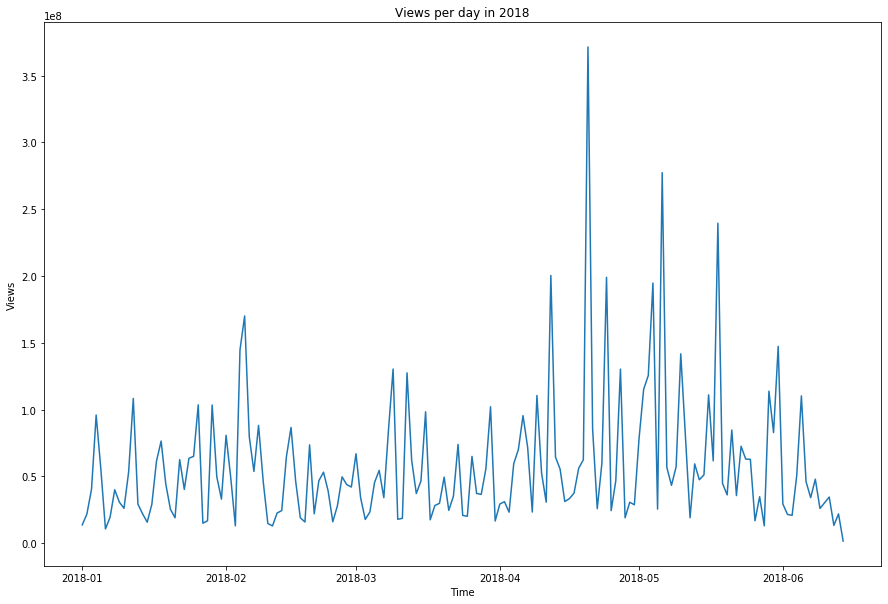

In [34]:
publish_date = []

for index, row in yt_videos.iterrows():
    # Extract the date from the date-time object using regex
    date = re.search(r"[0-9]{4}-[0-9]{2}-[0-9]{2}", row['publish_time'])
    publish_date.append(date.group())

# Add the new date column
yt_videos['publish_date'] = publish_date

# Convert the new date column to a datetime object
yt_videos['publish_date'] = pd.to_datetime(yt_videos['publish_date'])

# Sort the dataframe in ascending order by datetime
yt_videos = yt_videos.sort_values(by='publish_date')

views_per_day = {k:0 for k in yt_videos['publish_date']}
cutoff_date = datetime.datetime(2018,1,1)

# Only tally views on days that come on or after January 1, 2018
# This is because most of the data occurs in 2018
for index, row in yt_videos.iterrows():
    if row['publish_date'] >= cutoff_date:
        views_per_day[row['publish_date']] += row['views']

# Only consider views that are greater than zero
dates = [k for k,v in views_per_day.items() if v > 0] 
views = [v for k,v in views_per_day.items() if v > 0] 

# Draw the Time Series Plot
plt.figure(figsize=(15,10))
plt.plot(dates, views)
plt.xlabel("Time")
plt.title("Views per Day in 2018")
plt.ylabel("Views")
plt.show()